# The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2019 Semester 1
-----
## Project 1: Gaining Information about Naive Bayes
-----
###### Student Name(s): Renjie Meng
###### Python version: 3.6.5
###### Submission deadline: 1pm, Fri 5 Apr 2019

This iPython notebook is a template which you may use for your Project 1 submission. (You are not required to use it; in particular, there is no need to use iPython if you do not like it.)

Marking will be applied on the five functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

In [34]:
import random
import math
import matplotlib.pyplot as plt

In [35]:
# This function should open a data file in csv, and transform it into a usable format 
def preprocess(filepath):
    '''
    Read file by filepath, and make it into a 2-D list
    _____________________
    Parameter:
    filepath -> The filepath of dataset in csv format
    ____________________
    Return:
    A 2-D list which contains the content of the dataset passed in
    '''
    # open the csv file in a reading mode
    csv_file = open(filepath, 'r')
    # The dataset for storing data
    dataset = []
    
    # read the csv file line by line
    for line in csv_file.readlines():
        # Each line of the csv file represents an instance
        instance = line.split(',')
        # The split method above would capture the newline character '\n' at end of the line
        # Let's remove "\n" by list slicing
        instance[-1] = instance[-1][:-1]
        # Append current instance to the final dataset
        dataset.append(instance)
    # Finishing reading, close the file
    csv_file.close()
    
    # return the final dataset 
    return dataset

In [36]:
# This function should build a supervised NB model
def train(dataset):
    '''
    Generate prior and posterir distribution from the give dataset.
    The class atrribute is assumed to be at the last column of each instance. 
    _______________________________
    Parameter:
    dataset -> the trainning dataset in the form of 2-D list
    _______________________________
    Return:
    prior -> A dictionary contains prior distribution of classes, that is P(cj)
    posterior -> A dictionary contains posterior, that is P(xi|cj)
    '''
    return prior_calculator(dataset), posterior_calculator(dataset)

In [37]:
def prior_calculator(dataset):
    """
    Helper function for train(), responsible for calculating the prior probability of the given dataset
    _____________________
    Parameter:
    dataset -> given dataset for calculating prior
    _____________________
    Return:
    prior -> A dictionary represent the prior of the given dataset
    """
    
    prior = {}
    number_of_classes = 0
    for instance in dataset:
        the_class = instance[-1]
        # if the class attribute is missing, simply ignore it
        if the_class == '?':
            pass
         # if key is already seen before, just increase the count by 1
        elif the_class in prior:
            prior[the_class] += 1
            number_of_classes += 1
        # else create a new (key, value) pair and assign value to 1
        else:
            prior[the_class] = 1
            number_of_classes += 1
    
    # divide the prior counts by total number to get probability
    for the_class in prior.keys():
        prior[the_class] /= number_of_classes
    
    # All done, return the prior
    return prior

In [38]:
def posterior_calculator(dataset):
    """
    This posterior follow the data structure disscussed in lecture
    {attribute x: 
                {class c: 
                            {attribute_value: value}
                }
    }
   
    The posterior gives the probability after "Laplace smoothing", that is all count has a initial value of 1,
    
    P(xi|cj) = (1 + value_count)/(class_count + distinct_value_count_of_attribute)
    
    _________________________________
    Parameter:
    dataset -> The give dataset for calculating posterior distribution
    _________________________________
    Return:
    posterior -> A dictionary represents the posterior distribution, that is P(xi|cj)
    """
    # create the framework of the 3-D dictionary for posterior,   
    posterior = create_posterior_framework_with_Lapalce_smoothing(dataset)
    
    
    # total number of attributes
    n = len(dataset[0]) - 1
    
    # count the attribute occurence instance by instance
    for instance in dataset:
        # is the class has not be included in the dictionary, add it in.
        the_class = instance[-1]
            
        # feature means a attribute associated with value
        # count feature according to its class and attribute belongs to
        for attribute in range(n):
            feature = instance[attribute]
            # if the feature is missing, simply ignore it
            if feature == '?':
                pass
            else:
                posterior.get(attribute).get(the_class)[feature] += 1
    
    # do the last step of Laplace smoothing, divide attribtue count by (#class + # distinct attribute)
    all_classes = posterior.get(0).keys()
    
    for attr in range(n):
        for the_class in all_classes:
            # since we set initial value of each distinct value count to 1, then if we sum up all distinct value
            # then we actually get number_of_distinct_value + number_of_1, due to the initial value 1.
            num_of_classes_plus_num_of_distinct_values = sum(posterior.get(attr).get(the_class).values())
            for distinct_value in posterior.get(attr).get(the_class).keys():
                posterior.get(attr).get(the_class)[distinct_value] /= num_of_classes_plus_num_of_distinct_values
            
    return posterior

In [39]:
def create_posterior_framework_with_Lapalce_smoothing(dataset):
    '''
    Helper function of posterior_calculator.
    This function intend to create a data structure shown as below:
     {attribute x: 
                {class c: 
                            {attribute_value: 1}
                }
    }
    
    Note that the initial value of each attribute_value is 1, since I apply Laplace smoothing
    _________________________
    Parameter:
    dataset-> given dataset
    _________________________
    Return:
    posterior_framework -> The generated framework described above
    '''
    # the length of each instance => number of attributes in total
    n = len(dataset[0])
        
    # find distinct values of all attributes, include the class attribute
    # The data structure for storing information about distinct values is
    #
    # {attribute_1: [distinct_value_1, ..., distinct_value_n],
    # ....
    #  attribute_n: [distinct_value_1, ..., distinct_value_n],
    #  }
    
    attribute_distinct_value = {}     
    for i in range(n):
        attribute_distinct_value[i] = []
    
    for instance in dataset:
        for attr in range(n):
            feature = instance[attr]
            # if the attribute is missing, simply ignore it
            if feature == '?':
                pass
            elif feature not in attribute_distinct_value.get(attr):
                attribute_distinct_value[attr].append(feature)
                
                
    # generate posterior_framework depends on attribute_distinct_value
    num_attr = n - 1 # class attribute should be excluded
    posterior_framework = {}     
    for i in range(num_attr):
        posterior_framework[i] = {}
    
    # class attributes processing
    class_distinct_value = attribute_distinct_value.get(n-1)
    
    for attr in posterior_framework.keys():
        for the_class in class_distinct_value:
            posterior_framework.get(attr)[the_class] = {}
    
    # attribute processing
    for attr in posterior_framework.keys():
        for the_class in class_distinct_value:
            for distinct_value in attribute_distinct_value.get(attr):
                posterior_framework.get(attr).get(the_class)[distinct_value] = 1
    
    # All done!
    return posterior_framework

In [40]:
# This function should predict the class for an instance or a set of instances, based on a trained model 
def predict(test_set, prior, posterior):
    '''
    Predict the class label for each instance in test_set, the data structure of the result is:
    [ prediction1, prediction2, ..., prediction_n]
    If for some instance, there are several classes share the max probability, then predict the lable by 
    randomly choose one from these classes, this task is delegated to argmax(test_instance, prior, posterior).
    ____________________________
    Parameter:
    test_set -> A 2D list contains test instances 
    prior -> Given prior distribution, which is a dictionary
    posterior -> Given posterior distribution, which is a 3D dictionary.
    ____________________________
    Return:
    test_results -> A list of results.
    '''
    # use arg max to find the class with highes probability of generating one test instance, 
    # and do it for each instance
    test_results = []
    for test_instance in test_set:
        # arg max
        test_results.append(argmax(test_instance, prior, posterior))
        
    return test_results

In [41]:
def argmax(test_instance, prior, posterior):
    '''
    Find the class with largest probability for realizing the given test instance.
    If for some instance, there are several classes share the max probability, then predict the lable by 
    randomly choose one from these classes.
    ______________________________________
    Parameter:
    test_set -> A 2D list contains test instances 
    prior -> Given prior distribution, which is a dictionary
    posterior -> Given posterior distribution, which is a 3D dictionary.
    ______________________________________
    Return:
    curr_argmax_class -> The class with max probability
    '''
    # get list of all possible class from prior
    classes = list(prior.keys())
    # I set curr_argmax_class to a list, since there could be more than 1 class shre max probability
    curr_argmax_class = [classes[0]]
    curr_max_probability = probability_of_class_given_instance_calculator(test_instance, prior, posterior,
                                                                             classes[0])
    
    for the_class in classes[1:]:
        curr_prob = probability_of_class_given_instance_calculator(test_instance, prior, posterior,
                                                                             the_class)
        # handle class with same max probability
        if curr_prob == curr_max_probability:
            curr_argmax_class.append(the_class)
        elif curr_prob > curr_max_probability:
            curr_argmax_class = [the_class]
    
    # If there are more than one classes, choose one from them randomly
    if len(curr_argmax_class) > 1:
        curr_argmax_class = curr_argmax_class[random.randrange(0, len(curr_argmax_class)-1)]
    # If there is only one, make it into a scalar, that is not a container.
    else:
        curr_argmax_class = curr_argmax_class[0]
    return curr_argmax_class

In [42]:
def probability_of_class_given_instance_calculator(instance, prior, posterior, the_class):
    '''
    Calculat P(C=c|T=t) = prod(P(tj|C=c))*P(C = c)
    Applying log transformation =>  log(P(C=c|T=t)) = log(sum(P(tj|C=c)) + log(P(C = c))
    ________________________________________________
    Parameter:
    instance -> A test instances 
    prior -> Given prior distribution, which is a dictionary
    posterior -> Given posterior distribution, which is a 3D dictionary.
    the_class -> The given class
    ________________________________________________
    Return:
     posterior_probablity*prior.get(the_class) -> prod(P(tj|C=c))*P(C = c)
    '''
    posterior_probablity = 0
    for attr in range(len(instance) - 1):
        feature = instance[attr]
        # handle missing value by ignore it
        if feature == "?":
            pass
        # Apply log transformation 
        else:
            posterior_probablity += math.log(posterior.get(attr).get(the_class).get(feature))/math.log(2)
    return posterior_probablity + math.log(prior.get(the_class))/math.log(2)

In [43]:
# This function should evaluate a set of predictions, in a supervised context 
def evaluate(test_label, predict_label):
    '''
    This evaluation applies the Accuracy metrix, it cares about how often the classifier get correct. 
    ___________________________________
    Parameter:
    test_label -> A list of actually label corresponds to each instance
    predict_label -> A list of predicted label corresponds to each instance
    ___________________________________
    Return:
    correct/n -> Accuracy, which is how of the classifier get correct.
    '''
    correct = 0
    n = len(test_label)
    for i in range(n):
        if test_label[i] == predict_label[i]:
            correct += 1
    
    return correct/n

In [44]:
# This function should calculate the Information Gain of an attribute or a set of attribute, with respect to the class
def info_gain(dataset):
    '''
    Calculate the information gain of each attribtues with respect to the class distribution
    _____________________________
    Parameter:
    dataset -> the given dataset for calculating information gain
    _____________________________
    Return:
    IG -> A dictionary contains the final information gain.
    '''
    
    IG = {}
    Entropy_Of_Attributes = {}
    Entropy_Of_Attributes_Given_Class = {}
    # generate a list of int represents for attributes
    attributes = list(range(len(dataset[0][:-1])))
    
    # get distinct value of classes, and counting how many of each are ther
    classes = {}
    for instance in dataset:
        the_class = instance[-1]
        if the_class == '?':
            pass
        elif the_class not in classes:
            classes[the_class] = 1
        else:
            classes[the_class] += 1
    
    # initialize the 3 dictionaries, given each attribute initial value of 0.
    for attr in attributes:
        IG[attr] = 0
        Entropy_Of_Attributes[attr] = 0
        Entropy_Of_Attributes_Given_Class[attr] = 0
    
    # Calculate the entropy of each attribute
    for attr in attributes:
        distribution = get_attribute_distribution(dataset, attr)
        Entropy_Of_Attributes[attr] = H(distribution)
    
    # Calculate the entropy given the class
    class_count = sum(list(classes.values()))
    for attr in attributes:
        mean_info = 0
        for the_class in list(classes.keys()):
            # Partition the class with respect to the given class
            dataset_given_class = filter_dataset_by_class(dataset, the_class)
            distribution_of_attr_given_ = get_attribute_distribution(dataset_given_class, attr)
            new_entropy = H(distribution_of_attr_given_)
            mean_info += new_entropy*(classes.get(the_class)/class_count)
        Entropy_Of_Attributes_Given_Class[attr] = mean_info
        
        
    # Calculate IG by H(attribtue) - H(attribute|Class) = Information Gain
    for attr in attributes:
        IG[attr] = Entropy_Of_Attributes.get(attr) - Entropy_Of_Attributes_Given_Class.get(attr)
    
    
    return IG

In [45]:
def get_attribute_distribution(dataset, attr):
    '''
    Get the column belongs to the attr and make it into a list
    ______________________________________
    Parameter:
    dataset -> Given dataset
    attr -> Given attr to get
    ______________________________________
    Return:
    distribution -> A list of attr values
    '''
    distribution = []
    for instance in dataset:
        if instance[attr] != '?':
            distribution.append(instance[attr])
    return distribution

In [46]:
def H(distribution):
    '''
    Calculate the entropy of the distribution by H(X) = -1 * sum(P(X = x)*log2(P(X = x)))
    __________________________
    Paramater:
    distribution -> the given distribution for calculating
    __________________________
    Return:
    entropy -> the result of entropy
    '''
    # Find all distinct value and Count number of occurence of each distinct value
    distinct_values = {}     
    total_value_count = 0
    for value in distribution:
        # if the attribute is missing, simply ignore it
        if value == '?':
            pass
        elif value in distinct_values:
            distinct_values[value] += 1
            total_value_count += 1
        elif value not in distinct_values:
            distinct_values[value] = 1
            total_value_count += 1
        
    # Divide by total number to get probability and  Calculate the entropy
    entropy = 0
    for value in list(distinct_values.keys()):
        distinct_values[value] /= total_value_count
        entropy += -1 * distinct_values[value] * (math.log(distinct_values[value])/math.log(2))
    return entropy

In [47]:
def filter_dataset_by_class(dataset, the_class):
    '''
    Filter the dataset by given class, and return the result
    _________________________________
    Parameter:
    dataset -> Given dataset to filter
    the_class -> The class use to filter
    _________________________________
    Return:
    new_data_set -> the dataset only contains instances with the_class label
    '''
    new_data_set = []
    for instance in  dataset:
        if instance[-1] == the_class:
            new_data_set.append(instance)
    return new_data_set

In [48]:
# split dataset by index
car = preprocess("./2019S1-proj1-data_dos/car.csv")
split_number = round(len(car)*0.8)
training_set = car[:split_number]
test_set = car[split_number:]
prior, posterior = train(training_set)
test_label = [test_instance[-1] for test_instance in test_set]
predict_labels = predict(test_set, prior, posterior)
evaluate(test_label, predict_labels)

0.6763005780346821

In [49]:
# use the whole dataset as both training and test set
car = preprocess("./2019S1-proj1-data_dos/car.csv")
prior, posterior = train(car)
test_label = [test_instance[-1] for test_instance in car]
predict_labels = predict(car, prior, posterior)
evaluate(test_label, predict_labels)

0.8784722222222222

In [50]:
info_gain(car)

{0: 0.09644896916961399,
 1: 0.07370394692148596,
 2: 0.00448571662663233,
 3: 0.21966296333990787,
 4: 0.030008141247605202,
 5: 0.26218435655426364}

In [51]:
list(prior.keys())

['unacc', 'acc', 'vgood', 'good']

In [52]:
predict_labels

['unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',
 'unacc',


In [53]:
prior

{'unacc': 0.7002314814814815,
 'acc': 0.2222222222222222,
 'vgood': 0.03761574074074074,
 'good': 0.03993055555555555}

In [54]:
posterior

{0: {'unacc': {'vhigh': 0.29736408566721584,
   'high': 0.2677100494233937,
   'med': 0.2215815485996705,
   'low': 0.21334431630971992},
  'acc': {'vhigh': 0.18814432989690721,
   'high': 0.2809278350515464,
   'med': 0.29896907216494845,
   'low': 0.23195876288659795},
  'vgood': {'vhigh': 0.014492753623188406,
   'high': 0.014492753623188406,
   'med': 0.391304347826087,
   'low': 0.5797101449275363},
  'good': {'vhigh': 0.0136986301369863,
   'high': 0.0136986301369863,
   'med': 0.3287671232876712,
   'low': 0.6438356164383562}},
 1: {'unacc': {'vhigh': 0.29736408566721584,
   'high': 0.25947281713344317,
   'med': 0.2215815485996705,
   'low': 0.2215815485996705},
  'acc': {'vhigh': 0.18814432989690721,
   'high': 0.27319587628865977,
   'med': 0.29896907216494845,
   'low': 0.23969072164948454},
  'vgood': {'vhigh': 0.014492753623188406,
   'high': 0.2028985507246377,
   'med': 0.391304347826087,
   'low': 0.391304347826087},
  'good': {'vhigh': 0.0136986301369863,
   'high': 0.

Questions (you may respond in a cell or cells below):

1. The Naive Bayes classifiers can be seen to vary, in terms of their effectiveness on the given datasets (e.g. in terms of Accuracy). Consider the Information Gain of each attribute, relative to the class distribution — does this help to explain the classifiers’ behaviour? Identify any results that are particularly surprising, and explain why they occur.
2. The Information Gain can be seen as a kind of correlation coefficient between a pair of attributes: when the gain is low, the attribute values are uncorrelated; when the gain is high, the attribute values are correlated. In supervised ML, we typically calculate the Infomation Gain between a single attribute and the class, but it can be calculated for any pair of attributes. Using the pair-wise IG as a proxy for attribute interdependence, in which cases are our NB assumptions violated? Describe any evidence (or indeed, lack of evidence) that this is has some effect on the effectiveness of the NB classifier.
3. Since we have gone to all of the effort of calculating Infomation Gain, we might as well use that as a criterion for building a “Decision Stump” (1-R classifier). How does the effectiveness of this classifier compare to Naive Bayes? Identify one or more cases where the effectiveness is notably different, and explain why.
4. Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy. How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)
5. Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the Naive Bayes classifier? Explain why, or why not.
6. Naive Bayes is said to elegantly handle missing attribute values. For the datasets with missing values, is there any evidence that the performance is different on the instances with missing values, compared to the instances where all of the values are present? Does it matter which, or how many values are missing? Would a imputation strategy have any effect on this?

Don't forget that groups of 1 student should respond to question (1), and one other question of your choosing. Groups of 2 students should respond to question (1) and question (2), and two other questions of your choosing. Your responses should be about 150-250 words each.

In [55]:
datasets = ['anneal', 'breast-cancer', 'car', 'cmc', 'hepatitis', 'hypothyroid', 'mushroom', 'nursery',
           'primary-tumor']
root_path = './2019S1-proj1-data_dos/'
extension = '.csv'
file_paths = [root_path + name + extension for name in datasets]

In [56]:
def accuracy_of_NB_classifier(file_paths):
    accuracy_dict = {}
    for file_path in file_paths:
        dataset_name = file_path.split('/')[-1].split('.')[0]
        
        dataset =  preprocess(file_path)
        prior, posterior = train(dataset)
        actual_labels = [instance[-1] for instance in dataset]
        predict_labels = predict(dataset, prior, posterior)
        accuracy = evaluate(predict_labels, actual_labels)
        
        accuracy_dict[dataset_name] = accuracy
    return accuracy_dict

In [57]:
def info_gain_of_datasets(file_paths):
    info_gain_dict = {}
    for file_path in file_paths:
        dataset_name = file_path.split('/')[-1].split('.')[0]
        
        dataset =  preprocess(file_path)
        ig = info_gain(dataset)
        
        info_gain_dict[dataset_name] = ig
    return info_gain_dict

In [58]:
acc_dict = accuracy_of_NB_classifier(file_paths)

In [59]:
ig_dict = info_gain_of_datasets(file_paths)

In [60]:
def accuracy_report(acc_dict):
    datasets = sorted(acc_dict, key=lambda k: acc_dict[k], reverse=True)
    print("The accuracy table:")
    for dataset in datasets:
        print(dataset + " "+ str(acc_dict.get(dataset)))
        
    print('\n')
    accuracy_list = list(acc_dict.values())
    mean_accuracy = sum(accuracy_list)/len(accuracy_list)
    var_of_accu = sum([(accu - mean_accuracy)**2 for accu in accuracy_list])/len(accuracy_list)
    print("The mean accuracy is " + str(mean_accuracy))
    print("The max accuracy is " + str(max(accuracy_list)))
    print("The min accuracy is " + str(min(accuracy_list)))
    print("The std of accuracy is " + str(var_of_accu**0.5))
    return

In [61]:
def report(acc_dict, ig_dict):
    sepetator = "\n********************************************************************\n"
    datasets = sorted(acc_dict, key=lambda k: acc_dict[k], reverse=True)
    for dataset in datasets:
        info_gain_distribution = (ig_dict.get(dataset).values())
        print("Accuracy of " + dataset + " "+ str(acc_dict.get(dataset)))
        print("The max information gain among all attributes is " + str(max(info_gain_distribution)))
        print("The min information gain among all attributes is " + str(min(info_gain_distribution)))
        print(ig_dict.get(dataset))
        print(sepetator)
    
    return

In [62]:
def scatter_plot_IG(ig_dict, acc_dict):
    datasets = sorted(acc_dict, key=lambda k: acc_dict[k], reverse=True)
    for dataset in datasets:
        ig_distribution = list(ig_dict.get(dataset).values())
        plt.scatter(x=list(range(len(ig_distribution))), y=ig_distribution, )
        plt.legend(dataset)
        plt.xlim([0, 35])
        plt.ylim([0, 1])
        print(dataset + " Accuracy is " + str(acc_dict.get(dataset)))
        plt.show()

mushroom Accuracy is 0.9588872476612507


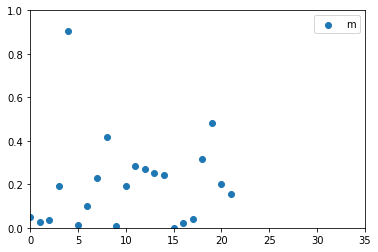

hypothyroid Accuracy is 0.9519443566234588


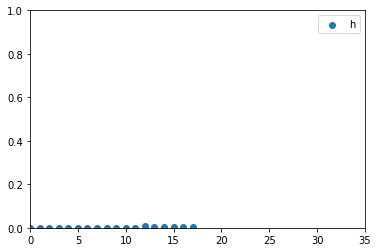

anneal Accuracy is 0.8930957683741648


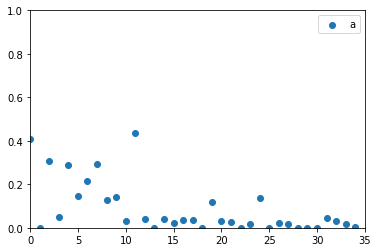

car Accuracy is 0.8784722222222222


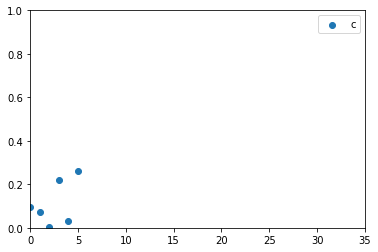

hepatitis Accuracy is 0.832258064516129


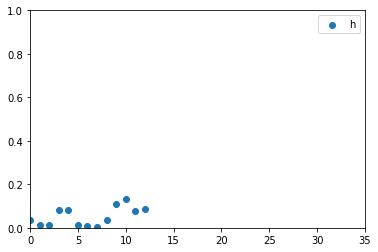

breast-cancer Accuracy is 0.7482517482517482


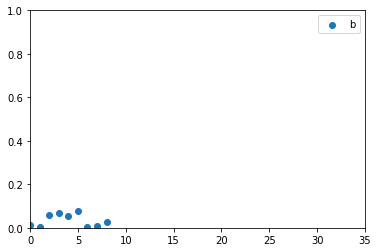

cmc Accuracy is 0.47997284453496264


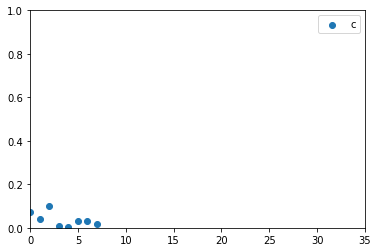

primary-tumor Accuracy is 0.40412979351032446


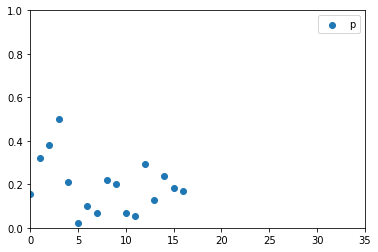

nursery Accuracy is 0.34930555555555554


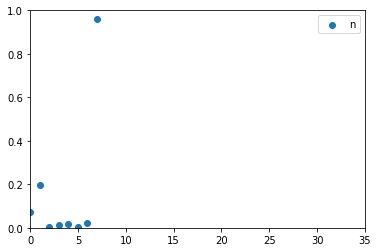

In [63]:
scatter_plot_IG(ig_dict, acc_dict)

In [64]:
accuracy_report(acc_dict)

The accuracy table:
mushroom 0.9588872476612507
hypothyroid 0.9519443566234588
anneal 0.8930957683741648
car 0.8784722222222222
hepatitis 0.832258064516129
breast-cancer 0.7482517482517482
cmc 0.47997284453496264
primary-tumor 0.40412979351032446
nursery 0.34930555555555554


The mean accuracy is 0.721813066805535
The max accuracy is 0.9588872476612507
The min accuracy is 0.34930555555555554
The std of accuracy is 0.22951948239436334


In [65]:
report(acc_dict, ig_dict)

Accuracy of mushroom 0.9588872476612507
The max information gain among all attributes is 0.9060749773839993
The min information gain among all attributes is 0.0
{0: 0.048796701935373, 1: 0.028590232773772817, 2: 0.03604928297620491, 3: 0.19237948576121977, 4: 0.9060749773839993, 5: 0.014165027250616413, 6: 0.10088318399657037, 7: 0.23015437514804604, 8: 0.41697752341613237, 9: 0.007516772569664099, 10: 0.1917403001149618, 11: 0.2847255992184845, 12: 0.27189447339274664, 13: 0.2538451734622398, 14: 0.24141556652756657, 15: 0.0, 16: 0.023817016120916856, 17: 0.03845266924309054, 18: 0.3180215107935378, 19: 0.48070491768491586, 20: 0.20195801906685262, 21: 0.15683360460509244}

********************************************************************

Accuracy of hypothyroid 0.9519443566234588
The max information gain among all attributes is 0.00935371021558018
The min information gain among all attributes is 4.463778824297451e-05
{0: 0.00024508445802418066, 1: 0.0009139351160850628, 2: 0.0012

In [66]:
import operator
d = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(x.items(), key=operator.itemgetter(1))

NameError: name 'x' is not defined

In [ ]:
sorted_x

In [ ]:
d = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted(d, key=lambda k: d[k])